In [106]:
# Import necessaries librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import wordcloud
from collections import Counter

import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , precision_score, recall_score, classification_report , accuracy_score , confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, SimpleRNN, Dense, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# We start by downloading spacy for the english language
# !python -m spacy download en_core_web_sm -q

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/MyDrive/spam.csv",encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
# only keep interesting columns and rename them
df = df[['v1', 'v2']]
df.columns = ['is_spam', 'message']
df.loc[:,'is_spam'] = [1 if mess == 'spam' else 0 for mess in df['is_spam']]
df.head()

<ipython-input-8-db975e19ce9f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'is_spam'] = [1 if mess == 'spam' else 0 for mess in df['is_spam']]
<ipython-input-8-db975e19ce9f>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'is_spam'] = [1 if mess == 'spam' else 0 for mess in df['is_spam']]


,is_spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


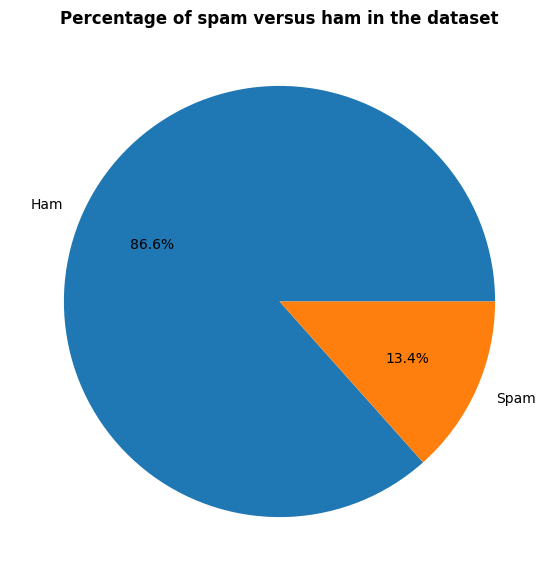

In [9]:
# Percentage of spam vs ham in the dataset

plt.figure(figsize=(14,7))
values = [len(df[df['is_spam'] == 0]) , len(df[df['is_spam'] == 1])]
labels = ['Ham' , 'Spam']

plt.pie(values, labels=labels, autopct='%1.1f%%', pctdistance=0.65, shadow=False)
plt.title("Percentage of spam versus ham in the dataset", fontsize=12, fontweight='bold')
plt.show()


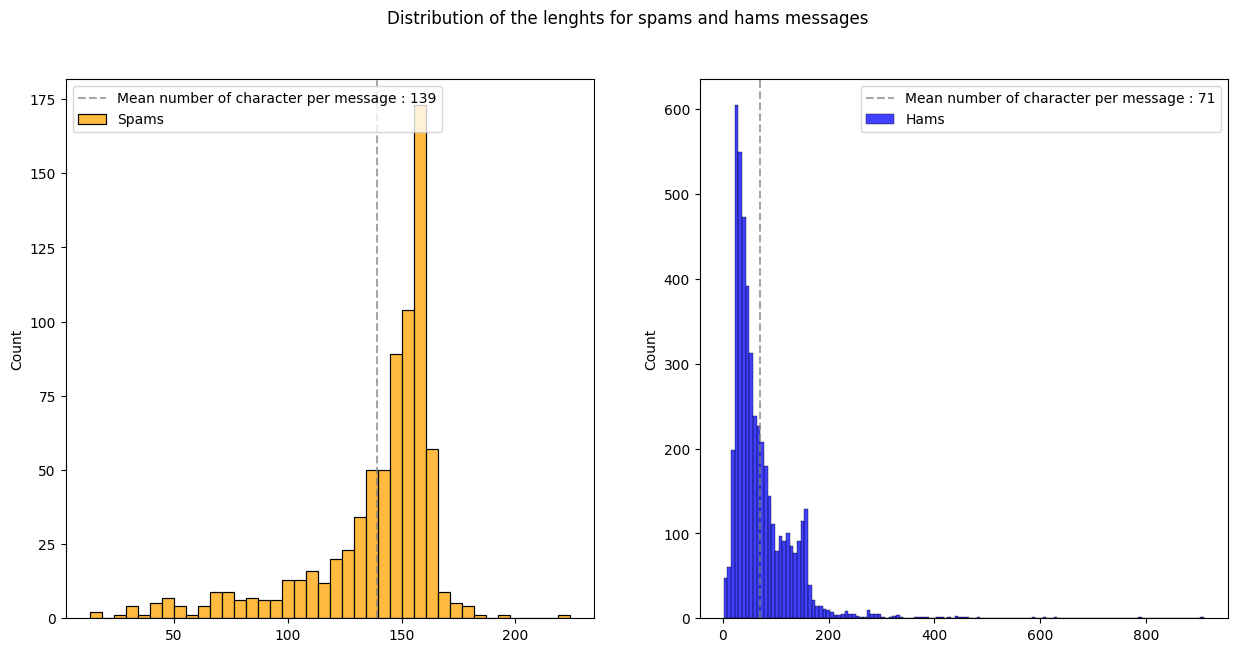

In [10]:
# Distribution of length of spams vs hams

df['length'] = df['message'].apply(len)
spam_length = df[df['is_spam'] == 1]['length'].values
ham_length = df[df['is_spam'] == 0]['length'].values

mean_spam_len = round(np.mean(spam_length))
mean_ham_len = round(np.mean(ham_length))


fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
sns.histplot(spam_length , ax=ax1 , label='Spams' , color='orange')
ax1.axvline(mean_spam_len , color='grey' , alpha=0.7 , linestyle='--' , label=f'Mean number of character per message : {mean_spam_len}')
ax1.legend(loc='upper left')

sns.histplot(ham_length , ax=ax2 , label='Hams' , color='blue')
ax2.axvline(mean_ham_len , color='grey' , alpha=0.7 , linestyle='--' , label=f'Mean number of character per message : {mean_ham_len}')
ax2.legend()

fig.suptitle('Distribution of the lenghts for spams and hams messages')
plt.show()

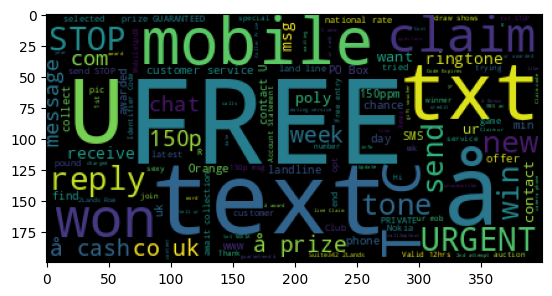

In [11]:
# Which are the most frequent words ?

nlp = en_core_web_sm.load()
spams = ' '.join(df[df['is_spam'] == 1]['message'])
doc = nlp(spams)

# Instanciate WordCloud with no stop words
wd = wordcloud.WordCloud(stopwords=STOP_WORDS)

# Generate word cloud
cloud = wd.generate(doc.text)
plt.imshow(cloud)
plt.show()



Over 5572 messages sent, approximately 13% are spam.

Also spam messages are twice longer than normal messages. The average number of spam messages contain 140 characters, whereas usual messages have an average of 70 characters. When observing the distribution of length of messages, most spam messages are over the average (140 characters), whereas the ham messages distribution is skewwd to the left : most messages are shorter than average, shorter than 70 characters.

The most common words found in spam messages are shown in the wordcloud. It is quite straightforward that spam messages include words like FREE, text mobile...

# Preprocessing


In [12]:
df.head()

,is_spam,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [13]:
# Remove all non alphanumeric characters except whitespaces
df["text_clean"] = df["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
#remove punctuations
df['text_clean'] = df['text_clean'].str.replace(r"[!\"#$%&()*+,-./:;<=>?@[\\\]^_`{|}~]+", " ")
# remove stop words and replace everyword with their lemma
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

<ipython-input-13-7d72b329e1ef>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text_clean'] = df['text_clean'].str.replace(r"[!\"#$%&()*+,-./:;<=>?@[\\\]^_`{|}~]+", " ")


In [15]:
df.head()

,is_spam,message,length,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live


In [40]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token = "out_of_vocab")
tokenizer.fit_on_texts(df['text_clean'])
df['text_encoded'] = tokenizer.texts_to_sequences(df['text_clean'])
df.head()

,is_spam,message,length,text_clean,text_encoded
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[3602, 230, 447, 463, 942, 36, 52, 204, 943, 7..."
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[10, 195, 464, 289, 2, 1453]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[13, 299, 4, 533, 664, 34, 1454, 851, 423, 145..."
3,0,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[2, 125, 150, 2354, 2, 85]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,"[709, 23, 665, 129]"


In [98]:
# Pad sequences
pad = tf.keras.preprocessing.sequence.pad_sequences(df['text_encoded'], padding="post")

# Train Test Split and make batches
xtrain, xval, ytrain, yval = train_test_split(pad, df['is_spam'], test_size=0.3, stratify=df["is_spam"])
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
test_ds = tf.data.Dataset.from_tensor_slices((xval, yval))

train_ds = train_ds.shuffle(len(train_ds)).batch(64)
test_ds = test_ds.shuffle(len(test_ds)).batch(64)

## Model embedding

In [100]:
vocab_size = tokenizer.num_words
embedding_dim = 16
model = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, embedding_dim,input_shape=[pad.shape[1],], name="embedding"),
                  GlobalAveragePooling1D(),
                  Dense(16, activation="relu"),
                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(1, activation="sigmoid")])
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_ds,
                    epochs=30,
                    validation_data=test_ds)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 16)            160016    
                                                                 
 global_average_pooling1d_18  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_48 (Dense)            (None, 16)                272       
                                                                 
 dense_49 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
61/61 [==============================] - 10s 127ms/step - loss: 0.6103 - binary_accuracy: 0.8659 - val

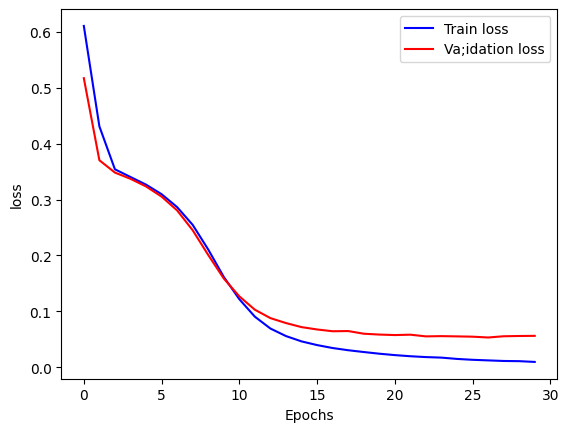

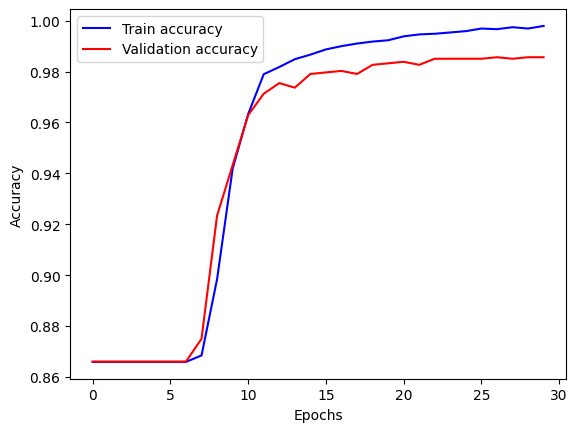

In [120]:
# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b", label = "Train loss")
plt.plot(history.history["val_loss"], color="r", label = "Va;idation loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

plt.plot(history.history["binary_accuracy"], color="b", label = "Train accuracy")
plt.plot(history.history["val_binary_accuracy"], color="r",label = "Validation accuracy" )
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

53/53 [==============================] - 0s 3ms/step


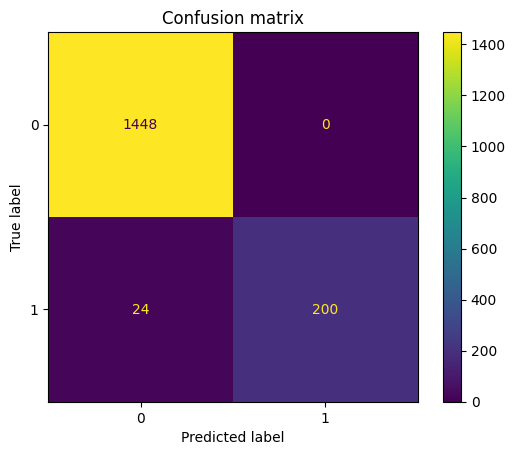


Classification report : 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       1.00      0.89      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672
 

F1 score :  0.943 

Accuracy score :  0.986 



In [124]:
# Get the model's predictions
ypred = np.round(model.predict(xval))
cm_test = confusion_matrix(yval, ypred)
ConfusionMatrixDisplay(cm_test).plot()
plt.title('Confusion matrix')
plt.show()

# Get the classification report
print('\nClassification report : \n')
print(classification_report(yval , ypred) , '\n')
print('F1 score : ' , round(f1_score(yval , ypred),3) , '\n')
print('Accuracy score : ' , round(accuracy_score(yval , ypred) , 3) , '\n')


The accuracy score is quite high ! Our model has a good accuracy in predicting if the message is spam or ham. In the case of ham messages, it can definitely predict well. If it's spam, there is a 10% chance that the prediction is wrong.